In [1]:
import sys
import numpy as np
import tensorflow as tf
#import matplotlib.pyplot as plt
# Generacion del grafico de metricas de Perdidas y Accuracy
import pandas as pd
import matplotlib.pyplot as plt
#ML
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.applications import *
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as k
from keras.models import Model

Using TensorFlow backend.


In [2]:
# fix seed for reproducible results (only works on CPU, not GPU)
#seed = 9
#np.random.seed(seed=seed)
#tf.set_random_seed(seed=seed)

# parameters dependent on your dataset: modified to your example
nb_train_samples = 690  # Total number of train samples. NOT including augmented images
nb_validation_samples = 346  # Total number of train samples. NOT including augmented images.
img_width, img_height = 299, 299  # change based on the shape/structure of your images

# hyper parameters for model
based_model_last_block_layer_number = 172  # value is based on based model selected.
batch_size = 64#8  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 10#100  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum

#Dataset 1
data_dir = './data/DDSM Images'
#data_dir = './data/DM images'
train_dir = data_dir + '/train'  # change to your train path. Inside, each class should have it's own folder
validation_dir = data_dir + '/validation'  # validation path. Inside, each class should have it's own folder

In [3]:
def load_base_model1():
    # Pre-Trained CNN Model using imagenet dataset for pre-trained weights
    base_model = InceptionV3(weights='imagenet', include_top=False)  # select from keras pre-built models library

    return base_model

def build_predictions1(base_model):
    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # softmax if multi-class classifiers
    #predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    
    return predictions

def build_predictions2(base_model):
    # Top Model Block
    x = base_model.layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # softmax if multi-class classifiers
    #predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    
    return predictions

def train(model, train_data_dir, validation_data_dir):
    
    #print('Base model')
    #base_model.summary()
    
    #model.summary()
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolution layers
    for layer in base_model.layers:
        layer.trainable = False

    # Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
    # To save augmentations un-comment save lines and add to your flow parameters.
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       #rotation_range=10,
                                       shear_range=.1,
                                       zoom_range=.1,
                                       cval=.1,
                                       horizontal_flip=True)
                                       #vertical_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='binary')
                                                        #save_to_dir=data_dir + '/preview',
                                                        #save_prefix='aug')#,
                                                        #save_format='jpeg')
    # use the above 3 commented lines if you want to save and look at how the data augmentations look like

    validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                            target_size=(img_height, img_width),
                                                            batch_size=batch_size,
                                                            class_mode='binary')

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])
    #  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    path_dir = data_dir.split('/')
    name_dir = path_dir[len(path_dir)-1]+'_twice'
    
    # save weights of best training epoch: monitor either val_loss or val_acc
    top_weights_path = 'model/top_model_weights'+name_dir+'.h5'
    checkpoint = ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    callbacks_list = [checkpoint]    

    # Train Simple CNN
    history_tl = model.fit_generator(train_generator,
                        samples_per_epoch=nb_train_samples,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=nb_validation_samples,
                        callbacks=callbacks_list)

    # add the best weights from the train top model
    # at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
    # we re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # verbose
    print("\nStarting to Fine Tune Model\n")

    # based_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last TWO blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=learn_rate, momentum=momentum),
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    
    final_weights_path = 'model/model_weights_'+name_dir+'.h5'
    checkpoint = ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='mode')
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    callbacks_list = [checkpoint]

    # fine-tune the model
    history_ft = model.fit_generator(train_generator,
                        samples_per_epoch=nb_train_samples,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=nb_validation_samples,
                        callbacks=callbacks_list)
    
    # save model
    model_json = model.to_json()
    with open('model/model'+name_dir+'.json', 'w') as json_file:
        json_file.write(model_json)
        
    return history_tl, history_ft, model
#Fin de función

#Preparar el modelo
base_model = load_base_model1()
# Top Model Block
predictions = build_predictions1(base_model)

# add your top layer block to your base model
pre_model = Model(base_model.input, predictions)
hist_tl, hist_ft, model = train(pre_model, train_dir, validation_dir)  # train model

Found 690 images belonging to 2 classes.
Found 346 images belonging to 2 classes.


/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=10, validation_data=<keras.pre..., validation_steps=346, epochs=2.0, callbacks=[<keras.ca...)`


Epoch 1/2
10/10 [==============================] - 144s 14s/step - loss: 0.7041 - acc: 0.8164 - val_loss: 0.3631 - val_acc: 0.8548
Epoch 2/2
10/10 [==============================] - 135s 13s/step - loss: 0.3670 - acc: 0.8649 - val_loss: 0.4693 - val_acc: 0.8555

Starting to Fine Tune Model



/home/grupoavatar/.local/lib/python3.5/site-packages/keras/callbacks.py:375: RuntimeWarning: ModelCheckpoint mode mode is unknown, fallback to auto mode.
  RuntimeWarning)
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:126: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:126: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=10, validation_data=<keras.pre..., validation_steps=346, epochs=10, callbacks=[<keras.ca...)`


Epoch 1/10
10/10 [==============================] - 141s 14s/step - loss: 0.2978 - acc: 0.8661 - val_loss: 0.4555 - val_acc: 0.8550
Epoch 2/10
10/10 [==============================] - 137s 14s/step - loss: 0.3286 - acc: 0.8567 - val_loss: 0.4389 - val_acc: 0.8553
Epoch 3/10
10/10 [==============================] - 137s 14s/step - loss: 0.3089 - acc: 0.8531 - val_loss: 0.4236 - val_acc: 0.8552
Epoch 4/10
10/10 [==============================] - 135s 13s/step - loss: 0.3040 - acc: 0.8493 - val_loss: 0.4107 - val_acc: 0.8551
Epoch 5/10
10/10 [==============================] - 135s 13s/step - loss: 0.2792 - acc: 0.8716 - val_loss: 0.3969 - val_acc: 0.8554
Epoch 6/10
10/10 [==============================] - 135s 14s/step - loss: 0.2926 - acc: 0.8578 - val_loss: 0.3839 - val_acc: 0.8556
Epoch 7/10
10/10 [==============================] - 135s 13s/step - loss: 0.2766 - acc: 0.8618 - val_loss: 0.3729 - val_acc: 0.8557
Epoch 8/10
10/10 [==============================] - 135s 14s/step - loss: 0.

In [4]:
#print(model_layers)
#print(model_layers.layers)

# let's visualize layer names and layer indices to see how many layers
# we should freeze: this is used to define based_model_last_block_layer_number
for i, layer in enumerate(model.layers):  # comment these two lines once the correct based_model_last_block_layer
    print(i, layer.name)  # has been selected
    
model.summary()

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, None, 1 114688      activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, None, 1 114688      activation_37[0][0]              
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, None, 1 384         conv2d_33[0][0]                  
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


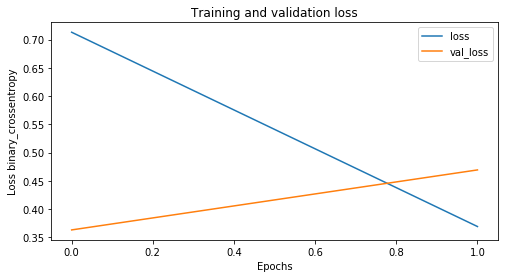

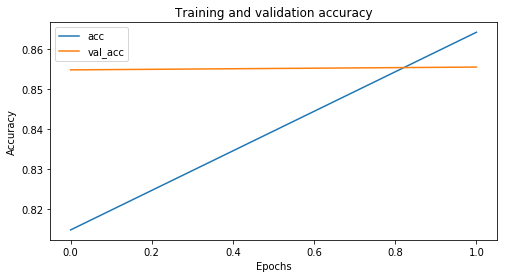

In [5]:
def plot_training2(history):
    #% matplotlib inline

    df = pd.DataFrame(history.history)
    # display(df)

    plot = df.plot(y=['loss', 'val_loss'], figsize=(8, 4), title='Training and validation loss', legend=True)
    plot.set_xlabel('Epochs')
    plot.set_ylabel('Loss binary_crossentropy')    
    fig = plot.get_figure()
    fig.savefig('loss_graph_t_cancer_t:'+str(nb_train_samples)+'smp_v:'+str(nb_validation_samples)+'smp_'+str(nb_epoch)+'epc.png')

    plot = df.plot(y=['acc', 'val_acc'], figsize=(8, 4), title='Training and validation accuracy', legend=True)
    plot.set_xlabel('Epochs')
    plot.set_ylabel('Accuracy')
    fig = plot.get_figure()
    fig.savefig('acc_graph_t_cancer_t:'+str(nb_train_samples)+'smp_v:'+str(nb_validation_samples)+'smp_'+str(nb_epoch)+'epc.png')
    
    plt.show()

#Transfer Learning    
plot_training2(hist_tl)

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


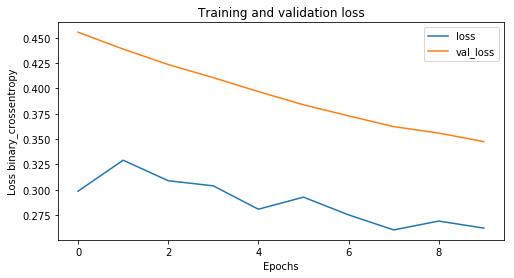

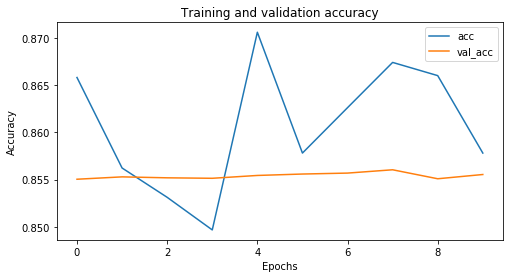

In [6]:
#Finetune
plot_training2(hist_ft)

In [8]:
from keras.models import model_from_json

#Dataset 2
#data_dir = './data/DDSM Images'
data_dir = './data/DM images'
train_dir = data_dir + '/train'  # change to your train path. Inside, each class should have it's own folder
validation_dir = data_dir + '/validation'  # validation path. Inside, each class should have it's own folder

def load_base_model2(data_dir):    
    path_dir = data_dir.split('/')
    name_dir = path_dir[len(path_dir)-1]

    # load json and create model
    json_file = open('model/model'+name_dir+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('model/model_weights_'+name_dir+'.h5')
    print("Loaded model from disk")
    
    #Esta sección es inncesaria
    # evaluate loaded model on test data
    loaded_model.compile(loss='binary_crossentropy',
                      optimizer=SGD(lr=learn_rate, momentum=momentum),
                      metrics=['accuracy'])
    #loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    validation_datagen = ImageDataGenerator(rescale=1. / 255)
    validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                            target_size=(img_height, img_width),
                                                            batch_size=batch_size,
                                                            class_mode='binary')

    score = loaded_model.evaluate_generator(validation_generator, batch_size)
    print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
    
    #loaded_model.summary()
    #Fin de la sección innecesaria
    
    #Remover las últimas cuatro capas
    for i in range(0, 4):
        loaded_model.layers.pop()
        
    #loaded_model.summary()
    
    loaded_model.compile(loss='binary_crossentropy',
                      optimizer=SGD(lr=learn_rate, momentum=momentum),
                      metrics=['accuracy'])
    
    return loaded_model


#Preparar el modelo

#Volver a hacer Transfer learning y Fine tune con el otro dataset
base_model = load_base_model2('./data/DDSM Images')

# Top Model Block
predictions = build_predictions2(base_model)

# add your top layer block to your base model
pre_model = Model(base_model.input, predictions)

hist_tl2, hist_ft2, _ = train(pre_model, train_dir, validation_dir)  # train model


Loaded model from disk
Found 56 images belonging to 2 classes.
acc: 33.93%
Found 80 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=10, validation_data=<keras.pre..., validation_steps=346, epochs=2.0, callbacks=[<keras.ca...)`


Epoch 1/2
10/10 [==============================] - 146s 15s/step - loss: 1.1859 - acc: 0.6506 - val_loss: 0.9199 - val_acc: 0.7500
Epoch 2/2
10/10 [==============================] - 128s 13s/step - loss: 0.5506 - acc: 0.7559 - val_loss: 0.6455 - val_acc: 0.7500

Starting to Fine Tune Model



/home/grupoavatar/.local/lib/python3.5/site-packages/keras/callbacks.py:375: RuntimeWarning: ModelCheckpoint mode mode is unknown, fallback to auto mode.
  RuntimeWarning)
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:126: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:126: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=10, validation_data=<keras.pre..., validation_steps=346, epochs=10, callbacks=[<keras.ca...)`


Epoch 1/10
10/10 [==============================] - 136s 14s/step - loss: 0.8538 - acc: 0.7270 - val_loss: 0.8810 - val_acc: 0.7500
Epoch 2/10
10/10 [==============================] - 132s 13s/step - loss: 0.8024 - acc: 0.7202 - val_loss: 0.8095 - val_acc: 0.7500
Epoch 3/10
10/10 [==============================] - 133s 13s/step - loss: 0.7735 - acc: 0.7441 - val_loss: 0.7447 - val_acc: 0.7500
Epoch 4/10
10/10 [==============================] - 132s 13s/step - loss: 0.6788 - acc: 0.7484 - val_loss: 0.6948 - val_acc: 0.7500
Epoch 5/10
10/10 [==============================] - 131s 13s/step - loss: 0.6050 - acc: 0.7595 - val_loss: 0.6597 - val_acc: 0.7500
Epoch 6/10
10/10 [==============================] - 133s 13s/step - loss: 0.5353 - acc: 0.7694 - val_loss: 0.6351 - val_acc: 0.7500
Epoch 7/10
10/10 [==============================] - 135s 13s/step - loss: 0.5257 - acc: 0.7668 - val_loss: 0.6204 - val_acc: 0.7500
Epoch 8/10
10/10 [==============================] - 132s 13s/step - loss: 0.

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


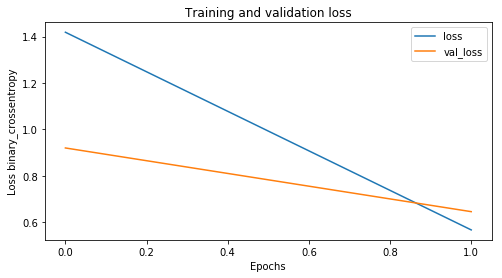

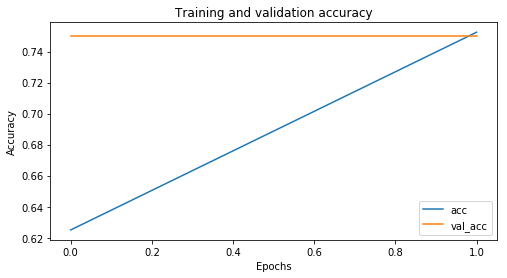

In [12]:
#Transfer Learning    
plot_training2(hist_tl2)

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


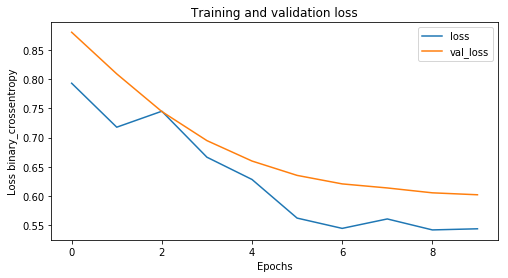

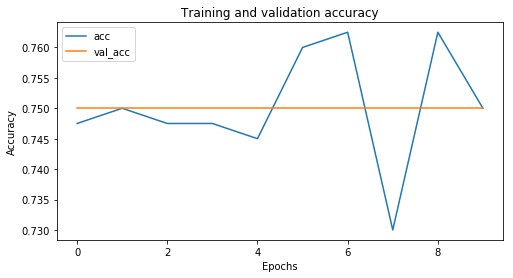

In [13]:
#Finetune
plot_training2(hist_ft2)

In [14]:
# release memory
k.clear_session()